In [1]:
# @title 1. Setup, Unzip & Library Installation
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import AutoTokenizer

In [2]:
!pip install -q transformers sentencepiece

ZIP_FILE_PATH = "/content/lnu-deep-learn-2-text-classification-2025.zip"
EXTRACT_PATH = "/content/data/"
MODEL_NAME = "dbmdz/bert-base-german-cased"


if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)

if os.path.exists(ZIP_FILE_PATH):
    print(f"Unzipping {ZIP_FILE_PATH}...")
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Extraction complete.")
else:
    print(f"Warning: Zip file not found at {ZIP_FILE_PATH}. Please check path or upload manually.")

files = [f for f in os.listdir(EXTRACT_PATH) if f.endswith('.csv')]
print(f"Found files: {files}")

train_file = next((f for f in files if 'train' in f.lower()), None)
test_file = next((f for f in files if 'test' in f.lower()), None)

if train_file:
    df_train = pd.read_csv(os.path.join(EXTRACT_PATH, train_file))
    print(f"Train data loaded: {df_train.shape}")
else:
    print("Could not find train file automatically.")

if test_file:
    df_test = pd.read_csv(os.path.join(EXTRACT_PATH, test_file))
    print(f"Test data loaded: {df_test.shape}")
else:
    print("Could not find test file automatically.")

Unzipping /content/lnu-deep-learn-2-text-classification-2025.zip...
Extraction complete.
Found files: ['test.csv', 'sample_submission.csv', 'train.csv']
Train data loaded: (9245, 3)
Test data loaded: (1028, 2)


/tmp/ipython-input-3421350443.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=LABEL_COL, data=df_train, palette='viridis')


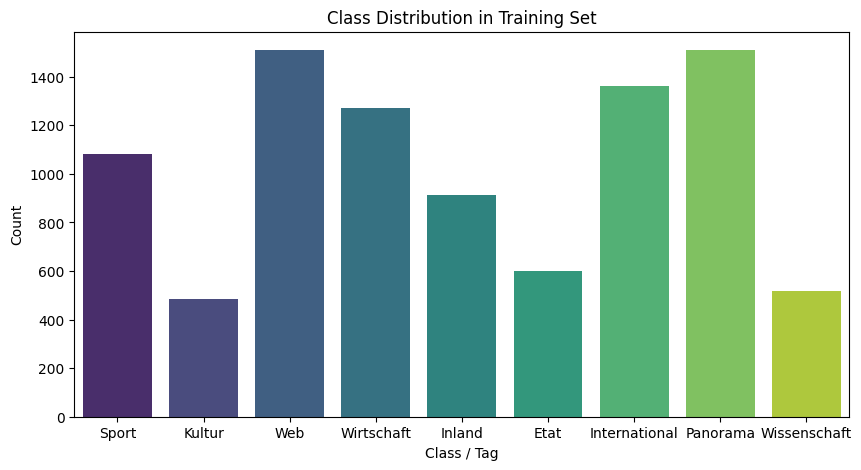


--- Class Balance ---
label
Panorama         16.333153
Web              16.322336
International    14.710654
Wirtschaft       13.737155
Sport            11.692807
Inland            9.875608
Etat              6.500811
Wissenschaft      5.581395
Kultur            5.246079
Name: proportion, dtype: float64


In [3]:
# @title 2. Data Analysis (EDA)
TEXT_COL = 'text'
LABEL_COL = 'label'


if train_file:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=LABEL_COL, data=df_train, palette='viridis')
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class / Tag')
    plt.ylabel('Count')
    plt.show()

    print("\n--- Class Balance ---")
    print(df_train[LABEL_COL].value_counts(normalize=True) * 100)

In [4]:
def get_text_metrics(df, text_col, tokenizer):
    texts = df[text_col].astype(str).tolist()

    token_counts = []
    unique_token_counts = []
    all_tokens = []

    print(f"Processing {len(texts)} texts with {tokenizer.name_or_path}...")

    for text in texts:
        tokens = tokenizer.tokenize(text)
        token_counts.append(len(tokens))
        unique_token_counts.append(len(set(tokens)))
        all_tokens.extend(tokens)

    return token_counts, unique_token_counts, all_tokens


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

metrics = {}
for name, df in [("Train", df_train), ("Test", df_test)]:
    if df is not None:
        print(f"\nAnalyzing {name} Data...")
        lens, uniques, tokens = get_text_metrics(df, TEXT_COL, tokenizer)
        metrics[name] = {
            "lengths": lens,
            "uniques": uniques,
            "tokens": tokens
        }

        print(f"--- {name} Statistics ---")
        print(f"Avg Length (tokens): {np.mean(lens):.2f}")
        print(f"Max Length (tokens): {np.max(lens)}")
        print(f"Avg Unique Tokens:   {np.mean(uniques):.2f}")
        print(f"Total Unique Vocab:  {len(set(tokens))}")

        common = Counter(tokens).most_common(10)
        print(f"Top 10 Tokens: {common}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (906 > 512). Running this sequence through the model will result in indexing errors



Analyzing Train Data...
Processing 9245 texts with dbmdz/bert-base-german-cased...
--- Train Statistics ---
Avg Length (tokens): 533.17
Max Length (tokens): 4512
Avg Unique Tokens:   296.32
Total Unique Vocab:  27607
Top 10 Tokens: [('.', 223139), (',', 192417), ('der', 98763), ('die', 91339), ('-', 63670), ('und', 63428), ('in', 57428), ('den', 36589), ('von', 32909), ('zu', 30270)]

Analyzing Test Data...
Processing 1028 texts with dbmdz/bert-base-german-cased...
--- Test Statistics ---
Avg Length (tokens): 540.89
Max Length (tokens): 6840
Avg Unique Tokens:   298.64
Total Unique Vocab:  23295
Top 10 Tokens: [('.', 25088), (',', 21973), ('der', 11235), ('die', 10013), ('und', 7210), ('-', 7100), ('in', 6543), ('den', 3976), ('von', 3587), ('zu', 3535)]


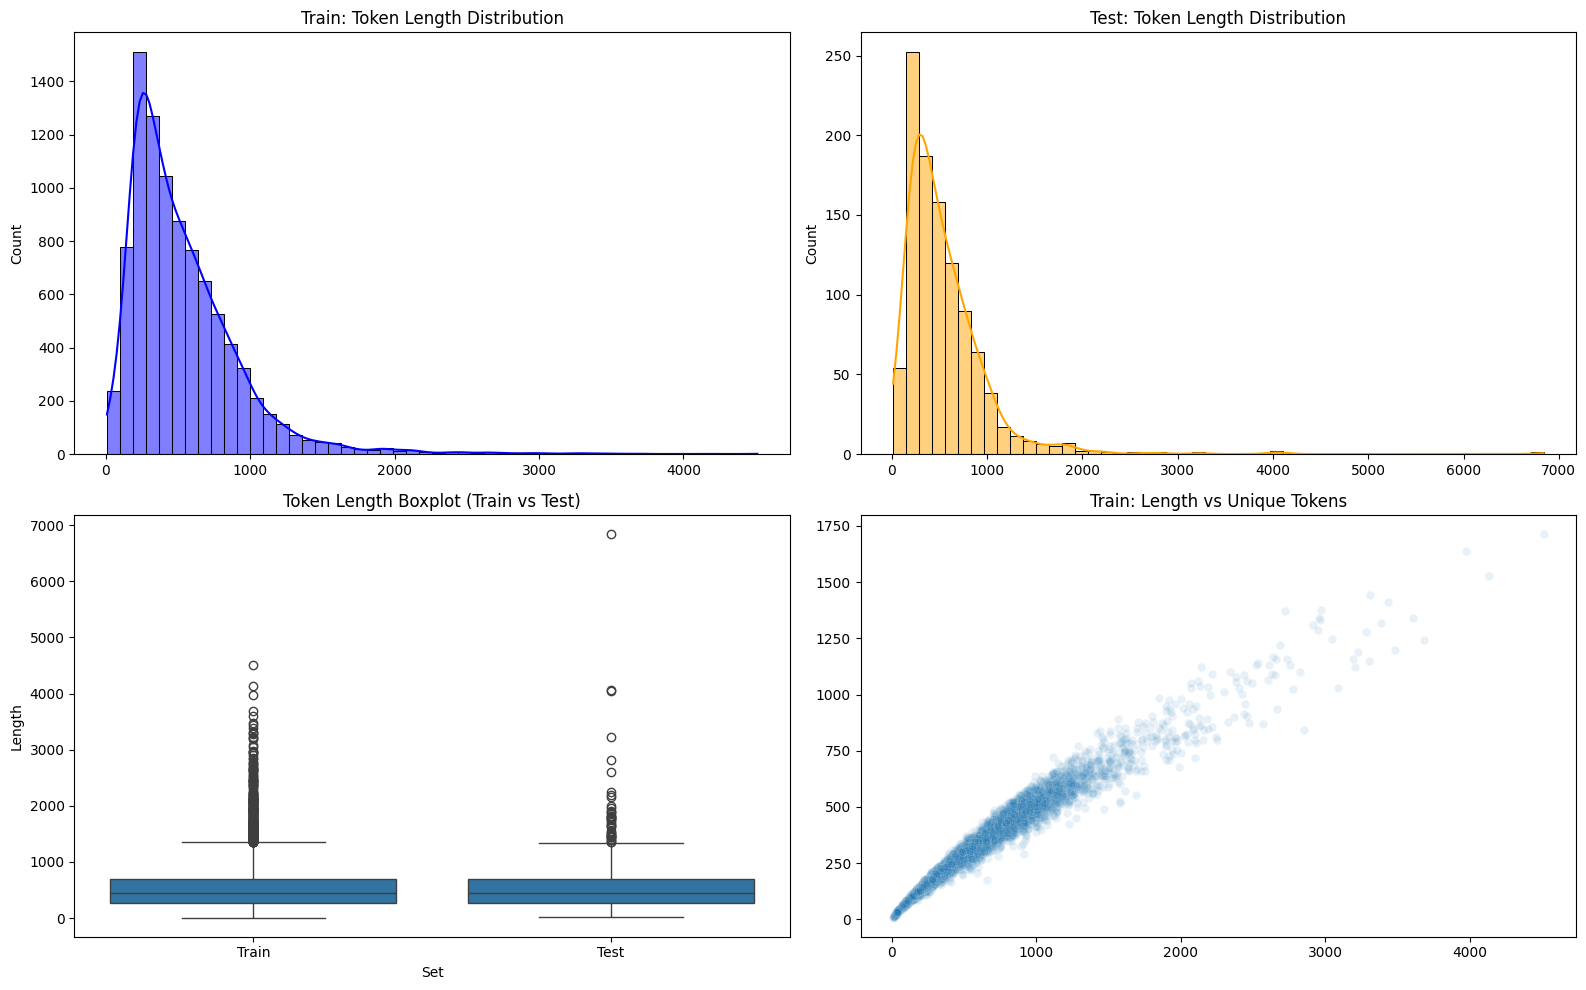

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))


sns.histplot(metrics["Train"]["lengths"], bins=50, ax=axes[0, 0], color='blue', kde=True)
axes[0, 0].set_title("Train: Token Length Distribution")


if "Test" in metrics:
    sns.histplot(metrics["Test"]["lengths"], bins=50, ax=axes[0, 1], color='orange', kde=True)
    axes[0, 1].set_title("Test: Token Length Distribution")


combined_lens = []
labels = []
combined_lens.extend(metrics["Train"]["lengths"])
labels.extend(["Train"] * len(metrics["Train"]["lengths"]))

if "Test" in metrics:
    combined_lens.extend(metrics["Test"]["lengths"])
    labels.extend(["Test"] * len(metrics["Test"]["lengths"]))

df_box = pd.DataFrame({"Length": combined_lens, "Set": labels})
sns.boxplot(x="Set", y="Length", data=df_box, ax=axes[1, 0])
axes[1, 0].set_title("Token Length Boxplot (Train vs Test)")


sns.scatterplot(x=metrics["Train"]["lengths"], y=metrics["Train"]["uniques"], alpha=0.1, ax=axes[1, 1])
axes[1, 1].set_title("Train: Length vs Unique Tokens")

plt.tight_layout()
plt.show()

In [6]:
# @title 3. Improved Preprocessing (Train Only)
import re
import html
import torch
import pickle
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm


def clean_german_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = " ".join(text.split())
    return text

print("Cleaning text (Normalization)...")
df_train['clean_text'] = df_train[TEXT_COL].apply(clean_german_text)


print("\nEncoding Labels...")
le = LabelEncoder()
df_train['label_ids'] = le.fit_transform(df_train[LABEL_COL])


with open(os.path.join(EXTRACT_PATH, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
print(f"Label map saved. Classes: {le.classes_}")


print(f"\nTokenizing with {MODEL_NAME}...")
texts = df_train['clean_text'].tolist()

encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)


save_path_pkl = os.path.join(EXTRACT_PATH, "train_processed.pkl")
save_path_pt = os.path.join(EXTRACT_PATH, "train_tensors.pt")

print(f"\nSaving to {save_path_pt}...")


df_train['input_ids'] = encoded_data['input_ids'].tolist()
df_train.to_pickle(save_path_pkl)


torch.save({
    'input_ids': encoded_data['input_ids'],
    'attention_mask': encoded_data['attention_mask'],
    'labels': torch.tensor(df_train['label_ids'].values, dtype=torch.long)
}, save_path_pt)

print("Train data normalized, encoded, and tokenized.")
print(f"Tensor Shape: {encoded_data['input_ids'].shape}")

Cleaning text (Normalization)...

Encoding Labels...
Label map saved. Classes: ['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']

Tokenizing with dbmdz/bert-base-german-cased...

Saving to /content/data/train_tensors.pt...
Train data normalized, encoded, and tokenized.
Tensor Shape: torch.Size([9245, 256])


In [7]:
!pip install -q mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.2/764.2 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.0 MB/s eta 0:00:00


In [8]:
# @title 8. Full Pipeline: Tuning -> Incremental Repeated CV -> Submission
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, RandomSampler, random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, get_linear_schedule_with_warmup
from sklearn.model_selection import RepeatedStratifiedKFold, ParameterGrid
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from tqdm.notebook import tqdm
import os
import pickle
import numpy as np
import re
import html
import mlflow
import json
import gc

# --- 1. CONFIGURATION ---
EXTRACT_PATH = "/content/data/"
MLFLOW_PATH = "/content/mlflow_logs_incremental"
os.makedirs(MLFLOW_PATH, exist_ok=True)
mlflow.set_tracking_uri(f"file://{MLFLOW_PATH}")
mlflow.set_experiment("LNU_Incremental_Training")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


config = {
    "model_name": "dbmdz/bert-base-german-cased",
    "n_splits": 5,
    "n_repeats": 2,
    "epochs_per_fold": 1,
    "lr": 2e-5,
    "batch_size": 32,
    "grad_accum_steps": 1,
    "seed": 42
}


param_grid = {
    "lr": [1e-5, 2e-5],
    "batch_size": [32]
}


def clean_german_text(text):
    if not isinstance(text, str): return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = " ".join(text.split())
    return text


print("Loading Data...")
with open(os.path.join(EXTRACT_PATH, "label_encoder.pkl"), "rb") as f:
    le = pickle.load(f)
num_labels = len(le.classes_)
class_names = list(le.classes_)

tensors_path = os.path.join(EXTRACT_PATH, "train_tensors.pt")
train_data = torch.load(tensors_path)

class GermanNewsDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data['input_ids']
        self.attention_mask = data['attention_mask']
        self.labels = data['labels']
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return {'input_ids': self.input_ids[idx], 'attention_mask': self.attention_mask[idx], 'labels': self.labels[idx]}

full_dataset = GermanNewsDataset(train_data)
all_labels = full_dataset.labels.numpy()


tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/11 19:14:32 INFO mlflow.tracking.fluent: Experiment with name 'LNU_Incremental_Training' does not exist. Creating a new experiment.


Loading Data...


In [9]:
# --- 4. HYPERPARAMETER TUNING SECTION ---
def train_epoch_tuning(model, dataloader, optimizer, scheduler, scaler, device, grad_accum_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(dataloader):
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(b_input, attention_mask=b_mask, labels=b_labels)
            loss = outputs.loss / grad_accum_steps

        scaler.scale(loss).backward()
        total_loss += loss.item() * grad_accum_steps

        if (step + 1) % grad_accum_steps == 0 or (step + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

    return total_loss / len(dataloader)

def validate_tuning(model, dataloader, device):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            b_input = batch['input_ids'].to(device)
            b_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(b_input, attention_mask=b_mask)
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            true_labels.extend(b_labels.cpu().numpy())
    return accuracy_score(true_labels, preds)

def find_best_hyperparameters(dataset, grid, base_cfg):
    print("\nSTARING HYPERPARAMETER TUNING...")

    # 80/20 Split for Tuning
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    best_score = 0
    best_params = {}

    grid_list = list(ParameterGrid(grid))

    for i, params in enumerate(grid_list):
        print(f"\nTrial {i+1}/{len(grid_list)}: {params}")

        torch.cuda.empty_cache()
        gc.collect()

        t_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True, collate_fn=data_collator, num_workers=2, pin_memory=True)
        v_loader = DataLoader(val_ds, batch_size=params['batch_size'], collate_fn=data_collator, num_workers=2, pin_memory=True)

        model = AutoModelForSequenceClassification.from_pretrained(base_cfg['model_name'], num_labels=num_labels).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=0.01)
        scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(t_loader) * 1) # 1 Epoch for tuning
        scaler = torch.amp.GradScaler('cuda')

        trial_best_acc = 0

        # Run 2 Epochs to test convergence speed
        for epoch in range(1):
            loss = train_epoch_tuning(model, t_loader, optimizer, scheduler, scaler, device, base_cfg['grad_accum_steps'])
            acc = validate_tuning(model, v_loader, device)
            print(f"   Ep {epoch+1}: Loss {loss:.4f} | Acc {acc:.4f}")
            if acc > trial_best_acc: trial_best_acc = acc

        if trial_best_acc > best_score:
            best_score = trial_best_acc
            best_params = params

        del model, optimizer, scaler

    print(f"\nBest Params: {best_params} (Acc: {best_score:.4f})")
    return best_params


best_params = find_best_hyperparameters(full_dataset, param_grid, config)
config.update(best_params)


STARING HYPERPARAMETER TUNING...

Trial 1/2: {'batch_size': 32, 'lr': 1e-05}


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Ep 1: Loss 1.1184 | Acc 0.8291

Trial 2/2: {'batch_size': 32, 'lr': 2e-05}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Ep 1: Loss 0.8150 | Acc 0.8556

Best Params: {'batch_size': 32, 'lr': 2e-05} (Acc: 0.8556)



Initializing dbmdz/bert-base-german-cased with Best Params...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Main Training: 10 Total Cycles...

Cycle 1/10 (Fold 1)


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   -> Train Loss: 0.7483 | Val Loss: 0.3887 | Acc: 0.8886

Cycle 2/10 (Fold 2)


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   -> Train Loss: 0.3097 | Val Loss: 0.2999 | Acc: 0.9054

Cycle 3/10 (Fold 3)


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   -> Train Loss: 0.2135 | Val Loss: 0.1809 | Acc: 0.9443

Cycle 4/10 (Fold 4)


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   -> Train Loss: 0.1371 | Val Loss: 0.0720 | Acc: 0.9816

Cycle 5/10 (Fold 5)


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   -> Train Loss: 0.0851 | Val Loss: 0.0465 | Acc: 0.9870

Cycle 6/10 (Fold 1)


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   -> Train Loss: 0.0466 | Val Loss: 0.0372 | Acc: 0.9903

Cycle 7/10 (Fold 2)


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   -> Train Loss: 0.0317 | Val Loss: 0.0285 | Acc: 0.9935

Cycle 8/10 (Fold 3)


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   -> Train Loss: 0.0225 | Val Loss: 0.0114 | Acc: 0.9978

Cycle 9/10 (Fold 4)


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   -> Train Loss: 0.0139 | Val Loss: 0.0018 | Acc: 0.9995

Cycle 10/10 (Fold 5)


Training:   0%|          | 0/232 [00:00<?, ?it/s]

   -> Train Loss: 0.0077 | Val Loss: 0.0082 | Acc: 0.9984

Generating Plots...


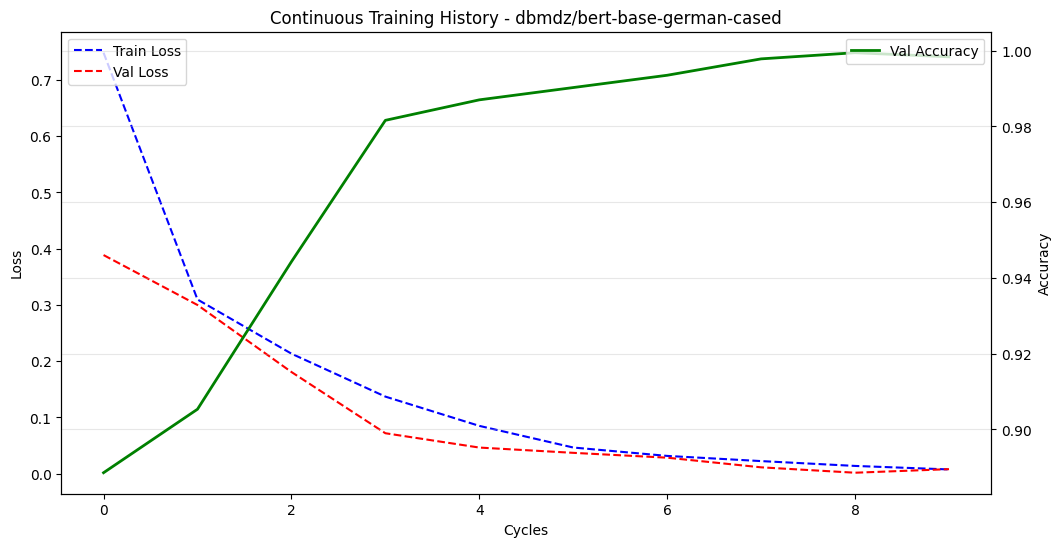

In [10]:
# --- 5. INITIALIZE PERSISTENT MODEL (ONCE) ---
print(f"\nInitializing {config['model_name']} with Best Params...")
model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=num_labels)
model.gradient_checkpointing_enable()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=0.01)
scaler = torch.amp.GradScaler('cuda')

total_folds = config['n_splits'] * config['n_repeats']
steps_per_fold = (len(full_dataset) // config['batch_size']) // config['grad_accum_steps']
total_training_steps = steps_per_fold * config['epochs_per_fold'] * total_folds
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_training_steps)

rskf = RepeatedStratifiedKFold(n_splits=config['n_splits'], n_repeats=config['n_repeats'], random_state=config['seed'])
global_history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
fold_counter = 0

with mlflow.start_run(run_name="Incremental_Repeated_CV_Run"):
    mlflow.log_params(config)
    print(f"Starting Main Training: {total_folds} Total Cycles...")

    for fold_idx, (train_idx, val_idx) in enumerate(rskf.split(np.zeros(len(all_labels)), all_labels)):
        fold_counter += 1
        print(f"\nCycle {fold_counter}/{total_folds} (Fold {fold_idx % config['n_splits'] + 1})")

        train_loader = DataLoader(full_dataset, batch_size=config['batch_size'], sampler=SubsetRandomSampler(train_idx), collate_fn=data_collator, num_workers=2, pin_memory=True)
        val_loader = DataLoader(full_dataset, batch_size=config['batch_size'], sampler=SubsetRandomSampler(val_idx), collate_fn=data_collator, num_workers=2, pin_memory=True)

        model.train()
        total_loss = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False)

        for step, batch in pbar:
            b_input = batch['input_ids'].to(device)
            b_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            with torch.amp.autocast('cuda'):
                outputs = model(b_input, attention_mask=b_mask, labels=b_labels)
                loss = outputs.loss / config['grad_accum_steps']

            scaler.scale(loss).backward()
            total_loss += loss.item() * config['grad_accum_steps']

            if (step + 1) % config['grad_accum_steps'] == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()
                if step % 50 == 0: pbar.set_postfix({'loss': f"{total_loss/(step+1):.4f}"})

        avg_train_loss = total_loss / len(train_loader)

        # Validate
        model.eval()
        val_loss = 0
        preds, true_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                b_input = batch['input_ids'].to(device)
                b_mask = batch['attention_mask'].to(device)
                b_labels = batch['labels'].to(device)
                with torch.amp.autocast('cuda'):
                    outputs = model(b_input, attention_mask=b_mask, labels=b_labels)
                val_loss += outputs.loss.item()
                preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
                true_labels.extend(b_labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        acc = accuracy_score(true_labels, preds)
        f1 = f1_score(true_labels, preds, average='weighted')

        # Log
        global_history['train_loss'].append(avg_train_loss)
        global_history['val_loss'].append(avg_val_loss)
        global_history['val_acc'].append(acc)
        global_history['val_f1'].append(f1)

        print(f"   -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f}")
        mlflow.log_metrics({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "val_acc": acc}, step=fold_counter)

    # --- 7. PLOTS & REPORTS ---
    print("\nGenerating Plots...")
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax1.plot(global_history['train_loss'], 'b--', label='Train Loss')
    ax1.plot(global_history['val_loss'], 'r--', label='Val Loss')
    ax1.set_xlabel('Cycles')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.plot(global_history['val_acc'], 'g-', linewidth=2, label='Val Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='upper right')

    plt.title(f"Continuous Training History - {config['model_name']}")
    plt.grid(True, alpha=0.3)
    mlflow.log_figure(plt.gcf(), "continuous_learning_curve.png")
    plt.show()

In [11]:
# --- 8. FINAL SANITY CHECK & SUBMISSION ---
print("\nFinal Evaluation on Training Data...")
model.eval()
train_preds, train_true = [], []
subset_sampler = RandomSampler(full_dataset, num_samples=int(len(full_dataset)*1)) # 100% check
sanity_loader = DataLoader(full_dataset, batch_size=32, sampler=subset_sampler, collate_fn=data_collator, num_workers=2, pin_memory=True)

with torch.no_grad():
    for batch in tqdm(sanity_loader, desc="Sanity Check"):
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        with torch.amp.autocast('cuda'):
            outputs = model(b_input, attention_mask=b_mask)
        train_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        train_true.extend(b_labels.cpu().numpy())

print("\n" + classification_report(le.inverse_transform(train_true), le.inverse_transform(train_preds)))

print("\nGenerating Submission...")
files = [f for f in os.listdir(EXTRACT_PATH) if f.endswith('.csv')]
test_file = next((f for f in files if 'test' in f.lower()), None)
df_test = pd.read_csv(os.path.join(EXTRACT_PATH, test_file))
df_test['clean_text'] = df_test['text'].apply(clean_german_text)

test_encodings = tokenizer.batch_encode_plus(df_test['clean_text'].tolist(), add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')

class TestDataset(Dataset):
    def __init__(self, encodings):
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
    def __len__(self): return len(self.input_ids)
    def __getitem__(self, idx): return {'input_ids': self.input_ids[idx], 'attention_mask': self.attention_mask[idx]}

test_loader = DataLoader(TestDataset(test_encodings), batch_size=16, shuffle=False, collate_fn=data_collator)

all_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Inference"):
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)
        with torch.amp.autocast('cuda'):
            outputs = model(b_input, attention_mask=b_mask)
        all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())

final_labels = le.inverse_transform(all_preds)
id_col = df_test['id'] if 'id' in df_test.columns else range(len(final_labels))
submission = pd.DataFrame({'id': id_col, 'label': final_labels})
save_path = "/content/submission_incremental.csv"
submission.to_csv(save_path, index=False)
print(f"DONE! Submission saved to {save_path}")


Final Evaluation on Training Data...


Sanity Check:   0%|          | 0/289 [00:00<?, ?it/s]


               precision    recall  f1-score   support

         Etat       1.00      1.00      1.00       601
       Inland       1.00      1.00      1.00       913
International       1.00      1.00      1.00      1360
       Kultur       1.00      1.00      1.00       485
     Panorama       1.00      1.00      1.00      1510
        Sport       1.00      1.00      1.00      1081
          Web       1.00      1.00      1.00      1509
   Wirtschaft       1.00      1.00      1.00      1270
 Wissenschaft       1.00      1.00      1.00       516

     accuracy                           1.00      9245
    macro avg       1.00      1.00      1.00      9245
 weighted avg       1.00      1.00      1.00      9245


Generating Submission...


Inference:   0%|          | 0/65 [00:00<?, ?it/s]

DONE! Submission saved to /content/submission_incremental.csv


In [14]:
# @title Download MLflow Logs
import shutil
import os
from google.colab import files

FOLDER_TO_ZIP = "/content/mlflow_logs_incremental"
OUTPUT_FILENAME = "mlflow_backup"

if os.path.exists(FOLDER_TO_ZIP):
    print(f"Zipping '{FOLDER_TO_ZIP}'...")

    zip_path = shutil.make_archive(f"/content/{OUTPUT_FILENAME}", 'zip', FOLDER_TO_ZIP)

    print(f"Created: {zip_path}")
    print(f"Starting download... (Check your browser downloads)")

    files.download(zip_path)
else:
    print(f"Error: The folder '{FOLDER_TO_ZIP}' does not exist.")
    print(" Did you name it something else? Check the file browser on the left.")

Zipping '/content/mlflow_logs_incremental'...
Created: /content/mlflow_backup.zip
Starting download... (Check your browser downloads)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Running Deep Dive Sanity Check


Evaluating:   0%|          | 0/289 [00:00<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

         Etat       1.00      1.00      1.00       601
       Inland       1.00      1.00      1.00       913
International       1.00      1.00      1.00      1360
       Kultur       1.00      1.00      1.00       485
     Panorama       1.00      1.00      1.00      1510
        Sport       1.00      1.00      1.00      1081
          Web       1.00      1.00      1.00      1509
   Wirtschaft       1.00      1.00      1.00      1270
 Wissenschaft       1.00      1.00      1.00       516

     accuracy                           1.00      9245
    macro avg       1.00      1.00      1.00      9245
 weighted avg       1.00      1.00      1.00      9245



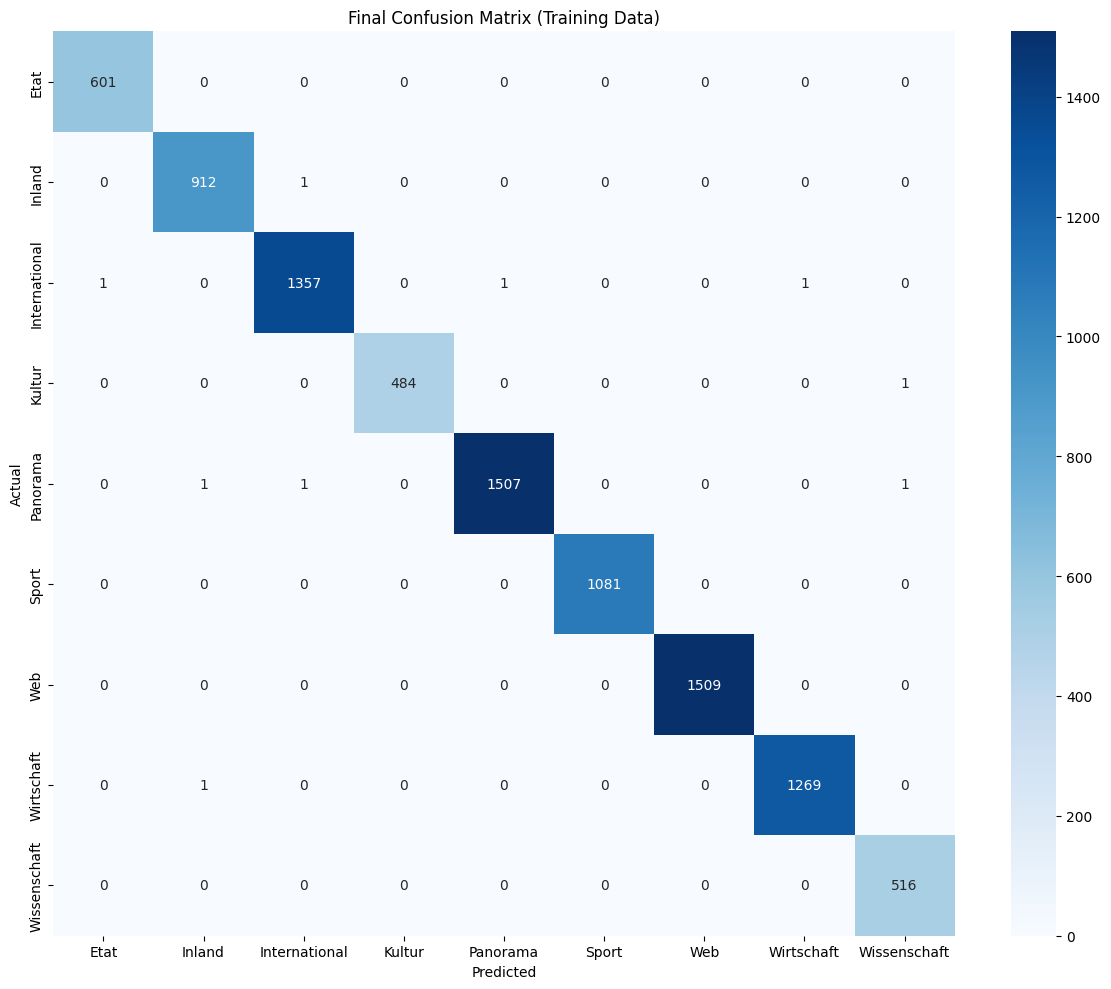


Correct Prediction Examples:
  True Label Predicted Label  Is Correct
0        Web             Web        True
1        Web             Web        True
2   Panorama        Panorama        True
3     Inland          Inland        True
4      Sport           Sport        True

Incorrect Prediction Examples (Where did it fail?):
         True Label Predicted Label  Is Correct
155   International            Etat       False
1229     Wirtschaft          Inland       False
2718  International        Panorama       False
2856       Panorama          Inland       False
2992         Inland   International       False

All evaluation files saved to: /content/evaluation_results


In [15]:
# @title 8. Final Sanity Check: Deep Dive Evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, RandomSampler
from tqdm.notebook import tqdm
import os

print("\nRunning Deep Dive Sanity Check")

EVAL_PATH = "/content/evaluation_results"
os.makedirs(EVAL_PATH, exist_ok=True)

subset_sampler = RandomSampler(full_dataset, num_samples=len(full_dataset))
sanity_loader = DataLoader(
    full_dataset,
    batch_size=32,
    sampler=subset_sampler,
    collate_fn=data_collator,
    num_workers=2,
    pin_memory=True
)

model.eval()
train_preds = []
train_true = []
train_indices = []


with torch.no_grad():
    for i, batch in enumerate(tqdm(sanity_loader, desc="Evaluating")):
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(b_input, attention_mask=b_mask)

        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = b_labels.cpu().numpy()

        train_preds.extend(preds)
        train_true.extend(labels)

pred_names = le.inverse_transform(train_preds)
true_names = le.inverse_transform(train_true)
class_names = list(le.classes_)


print("\nClassification Report:")
report_str = classification_report(true_names, pred_names, target_names=class_names)
print(report_str)

with open(f"{EVAL_PATH}/classification_report.txt", "w") as f:
    f.write(report_str)

cm = confusion_matrix(true_names, pred_names, labels=class_names)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Final Confusion Matrix (Training Data)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f"{EVAL_PATH}/confusion_matrix.png")
plt.show()


results_df = pd.DataFrame({
    'True Label': true_names,
    'Predicted Label': pred_names,
    'Is Correct': [t == p for t, p in zip(true_names, pred_names)]
})

results_df.to_csv(f"{EVAL_PATH}/training_predictions.csv", index=False)

print("\nCorrect Prediction Examples:")
print(results_df[results_df['Is Correct'] == True].head(5))

print("\nIncorrect Prediction Examples (Where did it fail?):")
print(results_df[results_df['Is Correct'] == False].head(5))

print(f"\nAll evaluation files saved to: {EVAL_PATH}")

In [16]:
# @title Download Evaluation
import shutil
import os
from google.colab import files

FOLDER_TO_ZIP = "/content/evaluation_results"
OUTPUT_FILENAME = "evaluation"

if os.path.exists(FOLDER_TO_ZIP):
    print(f"Zipping '{FOLDER_TO_ZIP}'...")

    zip_path = shutil.make_archive(f"/content/{OUTPUT_FILENAME}", 'zip', FOLDER_TO_ZIP)

    print(f"Created: {zip_path}")
    print(f"Starting download... (Check your browser downloads)")

    files.download(zip_path)
else:
    print(f"Error: The folder '{FOLDER_TO_ZIP}' does not exist.")
    print(" Did you name it something else? Check the file browser on the left.")

Zipping '/content/evaluation_results'...
Created: /content/evaluation.zip
Starting download... (Check your browser downloads)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# @title 8. Final Sanity Check: Deep Dive with Text & Confidence Analysis
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import os
import numpy as np


print("\nRunning Deep Dive Analysis")
EVAL_PATH = "/content/evaluation_results_deep"
os.makedirs(EVAL_PATH, exist_ok=True)


files = [f for f in os.listdir(EXTRACT_PATH) if f.endswith('.csv')]
train_file = next((f for f in files if 'train' in f.lower()), None)
df_analysis = pd.read_csv(os.path.join(EXTRACT_PATH, train_file))


analysis_loader = DataLoader(
    full_dataset,
    batch_size=32,
    sampler=SequentialSampler(full_dataset),
    collate_fn=data_collator,
    num_workers=2,
    pin_memory=True
)


model.eval()
all_preds = []
all_probs = []
all_true = []

with torch.no_grad():
    for batch in tqdm(analysis_loader, desc="Analyzing"):
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(b_input, attention_mask=b_mask)

        # Get Probabilities (Softmax) and Predictions
        probs = F.softmax(outputs.logits, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(max_probs.cpu().numpy())
        all_true.extend(b_labels.cpu().numpy())


pred_names = le.inverse_transform(all_preds)
true_names = le.inverse_transform(all_true)
class_names = list(le.classes_)


df_results = df_analysis.copy()
df_results['True_Label'] = true_names
df_results['Pred_Label'] = pred_names
df_results['Confidence'] = all_probs
df_results['Is_Correct'] = df_results['True_Label'] == df_results['Pred_Label']


csv_path = f"{EVAL_PATH}/deep_dive_predictions.csv"
df_results.to_csv(csv_path, index=False)
print(f"Detailed results saved to: {csv_path}")


Running Deep Dive Analysis


Analyzing:   0%|          | 0/289 [00:00<?, ?it/s]

Detailed results saved to: /content/evaluation_results_deep/deep_dive_predictions.csv



Classification Report:
               precision    recall  f1-score   support

         Etat       1.00      1.00      1.00       601
       Inland       1.00      1.00      1.00       913
International       1.00      1.00      1.00      1360
       Kultur       1.00      1.00      1.00       485
     Panorama       1.00      1.00      1.00      1510
        Sport       1.00      1.00      1.00      1081
          Web       1.00      1.00      1.00      1509
   Wirtschaft       1.00      1.00      1.00      1270
 Wissenschaft       1.00      1.00      1.00       516

     accuracy                           1.00      9245
    macro avg       1.00      1.00      1.00      9245
 weighted avg       1.00      1.00      1.00      9245



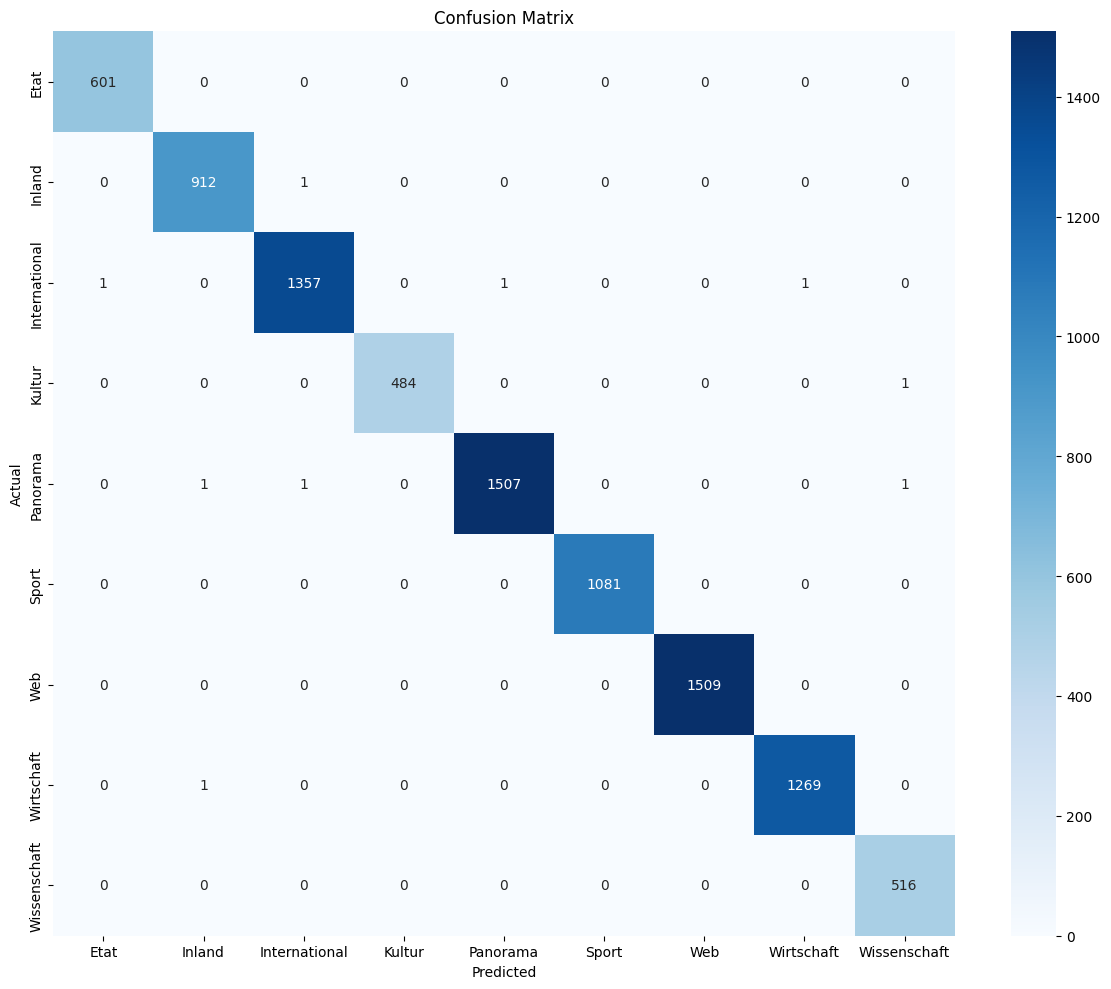

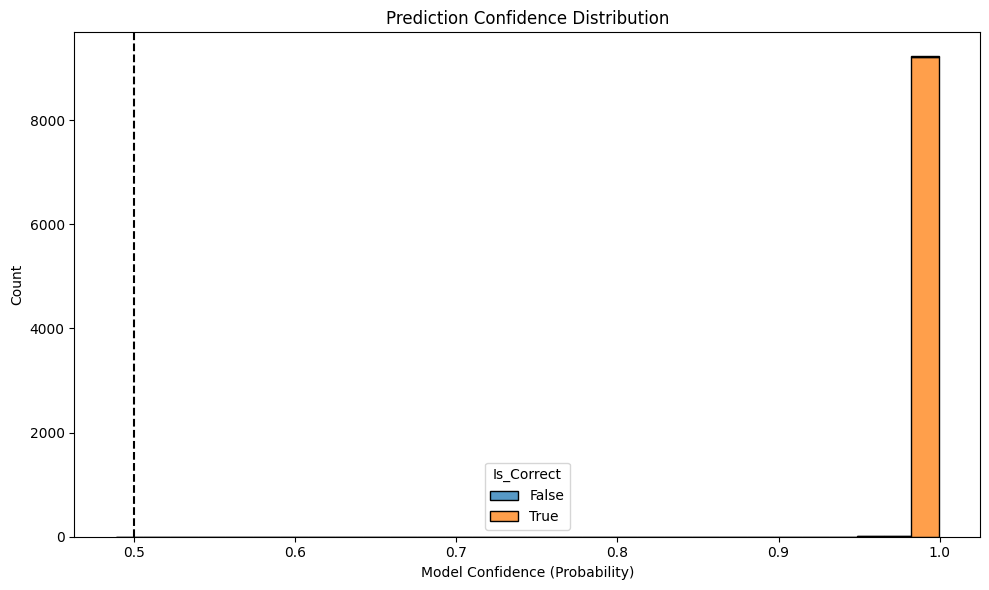

In [18]:
print("\nClassification Report:")
report = classification_report(true_names, pred_names, target_names=class_names)
print(report)
with open(f"{EVAL_PATH}/report.txt", "w") as f: f.write(report)


plt.figure(figsize=(12, 10))
cm = confusion_matrix(true_names, pred_names, labels=class_names)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(f"{EVAL_PATH}/confusion_matrix.png")
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(data=df_results, x='Confidence', hue='Is_Correct', multiple='stack', bins=30)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Model Confidence (Probability)')
plt.ylabel('Count')
plt.axvline(0.5, color='k', linestyle='--')
plt.tight_layout()
plt.savefig(f"{EVAL_PATH}/confidence_histogram.png")
plt.show()

In [19]:
text_col = TEXT_COL if 'TEXT_COL' in globals() else 'text'
id_col = 'id' if 'id' in df_results.columns else df_results.columns[0]

def print_examples(subset, title):
    print(f"\n{'='*20}\n {title} \n{'='*20}")
    for i, row in subset.iterrows():
        text_preview = str(row[text_col])[:150] + "..."
        print(f"ID: {row.get(id_col, i)} | Conf: {row['Confidence']:.4f}")
        print(f"Text: {text_preview}")
        print(f"True: {row['True_Label']}  |  Pred: {row['Pred_Label']}\n")

errors = df_results[df_results['Is_Correct'] == False].sort_values(by='Confidence', ascending=False)
print_examples(errors.head(5), "TOP 5 HIGH CONFIDENCE ERRORS (Model was sure but wrong)")

correct = df_results[df_results['Is_Correct'] == True].sort_values(by='Confidence', ascending=False)
print_examples(correct.head(3), "TOP 3 CORRECT PREDICTIONS")


 TOP 5 HIGH CONFIDENCE ERRORS (Model was sure but wrong) 
ID: be49de570b0243fd8bc9a6cc093a3858 | Conf: 0.9971
Text: Eine kriminalwissenschaftliche Analyse unterstützt bisherige These. London – Wissenschafter der Londoner Queen Mary Universität wollen mit Hilfe krimi...
True: Kultur  |  Pred: Wissenschaft

ID: 05fc99649be540ee9ca4fdb6e8bb36cf | Conf: 0.9844
Text: Nach Berichten über Waffenlieferungen an syrische Rebellen droht zwei Journalisten lebenslange Haft. Istanbul/Wien – Ein medienöffentliches Verfahren ...
True: International  |  Pred: Etat

ID: bdc9364fdd4d429998c6c0520d9538be | Conf: 0.9829
Text: Weniger Sitzungen, effizientere Strukturen und Mitglieder auf der Straße: Die SPÖ will in Wien wieder Boden gutmachen. Wien – Die SPÖ Wien will wieder...
True: Panorama  |  Pred: Inland

ID: aaba12340e6d430e9a3490d8131e00b1 | Conf: 0.9272
Text: Dichterin Friederike Mayröcker über das Nichtsuchen und Nichtfinden,  ihren Heiligen Geist der Erleuchtung und den Tod als Skandal. STANDARD:

In [20]:
# @title Download Evaluation
import shutil
import os
from google.colab import files

FOLDER_TO_ZIP = "/content/evaluation_results_deep"
OUTPUT_FILENAME = "evaluation_deep"

if os.path.exists(FOLDER_TO_ZIP):
    print(f"Zipping '{FOLDER_TO_ZIP}'...")

    zip_path = shutil.make_archive(f"/content/{OUTPUT_FILENAME}", 'zip', FOLDER_TO_ZIP)

    print(f"Created: {zip_path}")
    print(f"Starting download... (Check your browser downloads)")

    files.download(zip_path)
else:
    print(f"Error: The folder '{FOLDER_TO_ZIP}' does not exist.")
    print(" Did you name it something else? Check the file browser on the left.")

Zipping '/content/evaluation_results_deep'...
Created: /content/evaluation_deep.zip
Starting download... (Check your browser downloads)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>